# Exercise 2: Beamforming 

### Dr. Andrea Cossettini, Sergei Vostrikov, Sebastian Frey
#### TA: Cedric Hirschi, William Bruderer

# Working principle of ultrasound sensing

A single ultrasound measurement comprises 2 main steps:
- Excitation of ultrasound transducer
- Recording (data acquisition) of backscattered US signal

During the first step, we excite the transducer with a short electric pulse to create a pressure wave in the media.
The ultrasound transducer plays a key role in converting the energy from the electrical to the acoustical domain.

<img src='images/ex6_us_concept.drawio.png'>

Later, the generated acoustical pulse propagates deeper in the media.
If the media is homogenious and there are no reflections then the pulse propagates deeper.
However, in any case the amplitude of the pulse gradually decreases because of the tissue attenuation.

<img src='images/ex6_us_concept_1.drawio.png'>

If the acoustic pulse meets the boundary between 2 mediums of different density (such as the boundary of the scatter), we observe a reflection of the signal which we call backscattered (or echo) signal:

<img src='images/ex6_us_concept_2.drawio.png'>

Backscattered signal travels back and reaches the ultrasound transducer which converts the backscattered acoustical signal to the electrical domain.

At the same time, an Analog-to-Digital converter samples the electrical signal and digitizes it.

<img src='images/ex6_us_concept_3.drawio.png'>

We continiously sample the backscattered signal and finally get the time trace with reflections which we call raw ultrasound data.

# Single-channel A mode ultrasound

We will start the exercise by working with a simple **single-channel A-mode Ultrasound** signal.

Here **A-mode** stands for **amplitude mode**. It means we are interested in the amplitude of the backscattered ultrasound signal.

In [1]:
# Helper function to calculate FFT
def calc_fft(samples_arr, f_s):
    sp = np.fft.fft(samples_arr)
    freq = np.fft.fftfreq(samples_arr.shape[0], d=1/f_s)
    N = freq.shape[0]

    return freq[:int(N/2)], np.abs(sp[:int(N/2)])

### Bandwidth analysis

#### Let's analyze the frequency response of the transducer

The example below shows the simulated excitation pulse and its amplituide FFT spectrum. 

Particularly, we analyse the follolwing signal

$f\left(t\right) = sin\left(2\pi f_{signal} \cdot t\right)\cdot exp\left(-\dfrac{1}{2}\left(\dfrac{t - 5}{\sigma}\right)^{2}\right)$

over the interval $t\in[0, 10]$. 

As you can see, the test signal is a product of a sine wave with the frequency $f_{signal}$ and a Gaussian envelope.

- Play the duration of the pulse in the time domain (parameter `sigma`) and observe how the amplitude spectrum changes.

- Change also the sampling frequency (`f_s`) and the frequency of the sine wave (`f_signal`). Observe the changes in the amplitude spectrum.

- After experimentation, answer the quiz questions below.

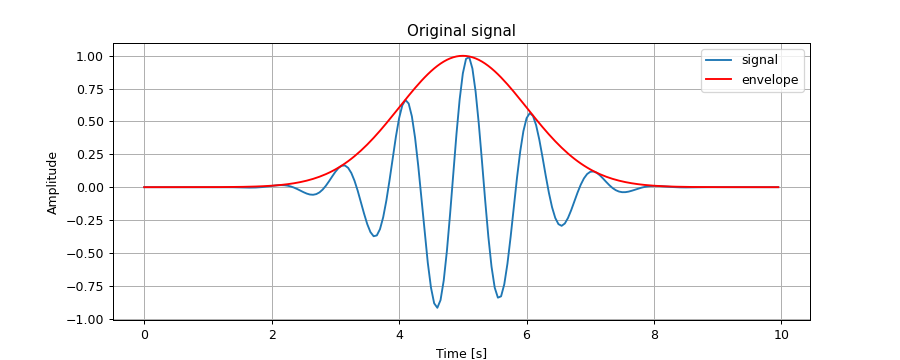

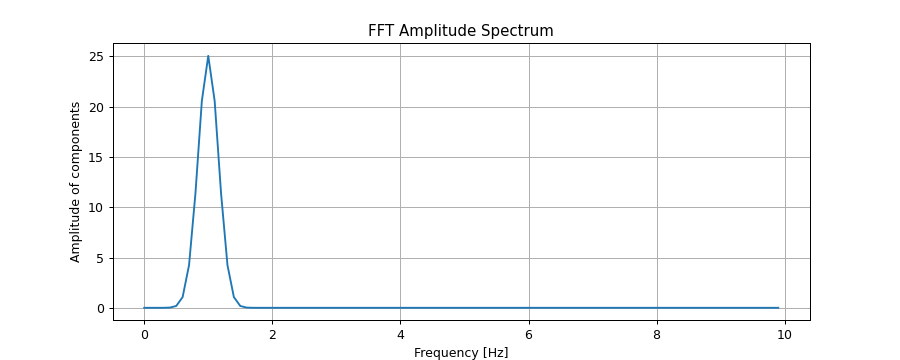

In [2]:
%matplotlib ipympl

import numpy as np
from matplotlib import pyplot as plt

# Sampling frequency [Hz]
f_s = 20

# Test signal frequency [Hz]
f_signal = 1

# Phase
phi = np.pi/3

# Envelope parameters
sigma = 1

# Make an array of time points [s]
# The last argument is a step between the timepoints.
# It is defined by the sampling period
t = np.arange(0,10, 1/f_s)

gauss_env = np.exp(-1/2*np.square((t - 5)/sigma))
f_data = np.sin(2*np.pi * f_signal * t + phi) * gauss_env

# Calculate FFT
freqs, fft = calc_fft(f_data, f_s)

# Plot the signal and its envelope
plt.figure(figsize=(10, 4), dpi=90)
plt.grid()
plt.plot(t, f_data, label='signal')
plt.plot(t, gauss_env, color='red', label='envelope')
plt.legend()
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('Original signal')
plt.show()

# Plot the FFT 
plt.figure(figsize=(10, 4), dpi=90)
plt.grid()
plt.plot(freqs, np.abs(fft))
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude of components')
plt.title('FFT Amplitude Spectrum')
plt.show()

## $\color{green}{\textbf{Quiz: bandwidth of the signal}}$

In [3]:
# Helper functions for quizzes
from jupyterquiz import display_quiz
from base64 import b64encode, b64decode
import json

def load_quiz(n):
    with open("quizzes/quiz_" + str(n) + ".raw", "rb") as f:
        data = f.read()

    data = json.loads(b64decode(data).decode('utf8'))
    display_quiz(data)

In [4]:
from jupyterquiz import display_quiz
load_quiz(1)

<IPython.core.display.Javascript object>

### Envelope Extraction

- In the previous warmup task you worked with a signal obtained by multiplying the sine wave (carrier) and the envelope.
- Execute a few cells below to recap the shape of the test waveform.

In [5]:
def get_test_signal(f_signal, f_s, sigma, phi):

    # Make an array of time points [s]
    # The last argument is a step between the timepoints.
    # It is defined by the sampling period
    t = np.arange(0,10, 1/f_s)

    gauss_env = np.exp(-1/2*np.square((t - 5)/sigma))
    f_data = np.sin(2*np.pi * f_signal * t + phi) * gauss_env
    
    return f_data, gauss_env, t

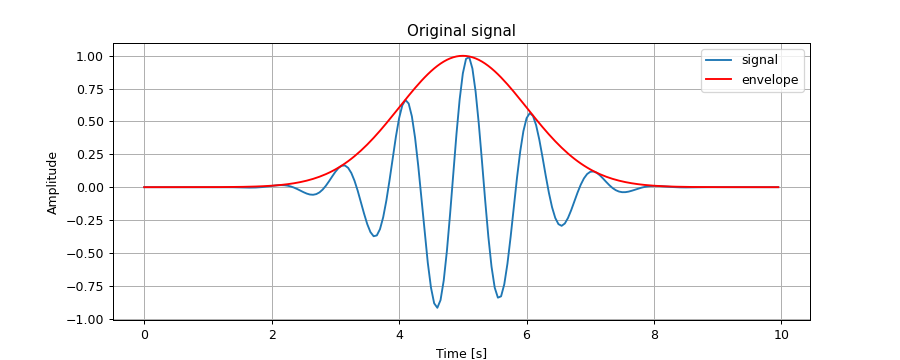

In [6]:
# Sampling frequency [Hz]
f_s = 20
# Test signal frequency [Hz]
f_signal = 1
# Phase
phi = np.pi/3
# Envelope parameters
sigma = 1

f_data, gauss_env,t = get_test_signal(f_signal, f_s, sigma, phi)

# Plot the signal and its envelope
plt.figure(figsize=(10, 4), dpi=90)
plt.grid()
plt.plot(t, f_data, label='signal')
plt.plot(t, gauss_env, color='red', label='envelope')
plt.legend()
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('Original signal')
plt.show()

- The **envelope** (max amplitude of the signal) **encodes the information we are interested in** and the carrier wave helps to transmit this information.

- This phenomenon is called **amplitude modulation (AM)** and is widely used in electronics, telecommunications.

- In ultrasound, **the envelope of the signal transmit information about the reflective structures** in the human tissue. At tissue discontinuities, part of the initially emitted pulse is reflected back. This pulse contains high oscillations, as in the image above.**The event of a reflection as such** is represented by the envelope of this pulse.

- Therefore, an important step of ultrasound signal processing is **envelope extraction**. You will learn in the next task how to do this.

## $\color{green}{\textbf{Task 1 : Implement the envelope extraction}}$

 ### $\color{green}{\textbf{Task 1.1: Get acquianted with the IQ demodulation}}$

One of the approaches to extract the envelope is based on the **IQ demodulation**. 

The diagram for IQ demodulator is shown below:

<img src='images/iq_demod.png'>

[figure source](https://www.allaboutcircuits.com/textbook/radio-frequency-analysis-design/radio-frequency-demodulation/understanding-quadrature-demodulation/)

- Here we have a Local Oscillator which produces a sine wave 

  $sin(2\pi f_{c}\cdot t)$ with a frequency $f_c$ which is a frequency of the carrier signal
  
  
- We then multiply the original radiofrequency (RF) signal by the above carrier signal and by its phase shifted version 

  ($cos(2\pi f_{c}\cdot t)$), followed by separate Low Pass filters (LPFs).
  
- By doing so, we generate two signals called **In-phase (I)** and **Quadrature (Q)** components. 
- They contain information about the envelope signal. 

- Let's explore what information we can extract from **IQ data.**

- Let's assume our RF signal is a sine wave with a frequency $f_c$ and a phase $\phi$ modulated by the function $A(t)$:

  $S_{RF}(t) = A(t)\cdot sin(2\pi f_{c}\cdot t + \phi)$
  
  
- After multiplying the RF signal by the carrier signal, we get the following:

  $A(t)\cdot sin(2\pi f_{c}\cdot t + \phi) \cdot sin(2\pi f_{c}\cdot t) =$ [Product of sines] $= \dfrac{A(t)}{2} (cos(\phi) - cos(4\pi f_{c}\cdot t + \phi))$
  
- As we can see above the product of multiplication has **a term with zero frequency** $cos(\phi)$ and **a term with doubled frequency of the carrier** $cos(2\pi (2f_{c})\cdot t + \phi)$.


- We would like to get rid of the second term. That is why we apply a Low pass filter and obtain the In-phase component:

  $\dfrac{A(t)}{2} (cos(\phi) - cos(4\pi f_{c}\cdot t + \phi)) \rightarrow$ [Low Pass Filter] $\rightarrow \dfrac{A(t)}{2} \cdot cos(\phi) = I(t)$
  
- Similarly, we get the following expression for Quadrature component:

  $ A(t)\cdot sin(2\pi f_{c}\cdot t + \phi) \cdot cos(2\pi f_{c}\cdot t) = \dfrac{A(t)}{2} \cdot (sin(4\pi f_{c}\cdot t + \phi) + sin(\phi)) \rightarrow$ [Low Pass filter] $\rightarrow \dfrac{A(t)}{2} \cdot sin(\phi) = Q(t)$
  
- To sum up, after IQ demodulation, we obtain the following I and Q signals:
  
  $I(t) = \dfrac{A(t)}{2} \cdot cos(\phi)$
  
  $Q(t) = \dfrac{A(t)}{2} \cdot sin(\phi)$
  
- From them, we can extract both the envelope and phase of the original signal:

  $A(t)	\propto \sqrt{I^2(t) + Q^2(t)}$ 
  
  $\phi	= arctan \left( \dfrac{Q(t)}{I(t)}\right)$ 

- A  simplified block diagram of the IQ demodulator is shown below. As you can see, this module relies on the output of the local oscillator.
- That means there is only one parameter we should know in advance. 
- It is the **frequency of the carrier $f_c$** which is a **central frequency of the ultrasound transducer**.
<img src='images/ex6_IQ_demod.drawio.png'>

- For your convinience, we prepared below the code implementing IQ demodulation.
- The function combines IQ demodulation with **decimation**.
- **Decimation** is a two-step **sample rate reduction method** where the data is **first filtered, then** samples are **discarded**

In [7]:
import scipy.signal as ss

# Demodulate Decimate (real - > complex IQ (or baseband signal) decimated)
# The 'data' argument is a real valued matrix
# Each column in input data represents the time sample, 
# Each row stands for channel
def demodulate_decimate(data, f_sampling, f_carrier, decimation_factor):

    # Create time array for the input samples
    time_arr = np.arange(0, data.shape[1], dtype=np.float32) / f_sampling

    # Create complex carrier wave
    carrier = 2 * np.exp(-1.j * 2 * np.pi * f_carrier * time_arr)

    # Demodulate the input data by multiplying it with complex carrier 
    # Each row of the matrix data is multiplied by the complex carrier
    data_demod = data * np.tile(carrier.reshape(1, -1), (data.shape[0], 1))

    # Decimate the data by the factor decimation_factor
    # The  function below first applies an anti-aliasing (low pass) filter and then deciate signal 
    data_DD = ss.decimate(data_demod, decimation_factor, zero_phase=True)

    # Real part of the complex array corresponds to the Quadrature component
    # Imaginery part corresponds to the In-phase component
    return data_DD.astype(np.complex64)

### $\color{green}{\textbf{Task 1.2: Play with the IQ demodulation}}$

Let's use the previously created test signal and extract the envelope. Complete the following tasks:

1. Run the code below with the default parameters (`decimation_factor=10`) and analyze the figures.
        - Does the extracted envelope match the original one?
        - What can you say about the Amplitude spectrum of the In-phase component? Can you explain it?
2. Change the `decimation_factor` from 10 to 1 and repeat calculations.
        - Does the extracted envelope still match the original one?
        - What can you say about the Amplitude spectrum of the In-phase component? Explain it.
**Hint**: Try different values of the `decimation_factor` parameter. Explore `demodulate_decimate` function and particularly `ss.decimate` method to answer the questions.

3. Discuss your answers with the TAs :)

In [8]:
# Parameters of the test signal

# Sampling frequency [Hz]
f_s = 20
# Test signal frequency [Hz]
f_signal = 1
# Phase
phi = np.pi/3
# Envelope parameters
sigma = 1

# Generate the test signal
f_data, gauss_env,t = get_test_signal(f_signal, f_s, sigma, phi)

In [9]:
# Parameters of the IQ demodulation
# Sampling rate reduction rate f_sampling_new = f_sampling/decimation_factor
decimation_factor = 10

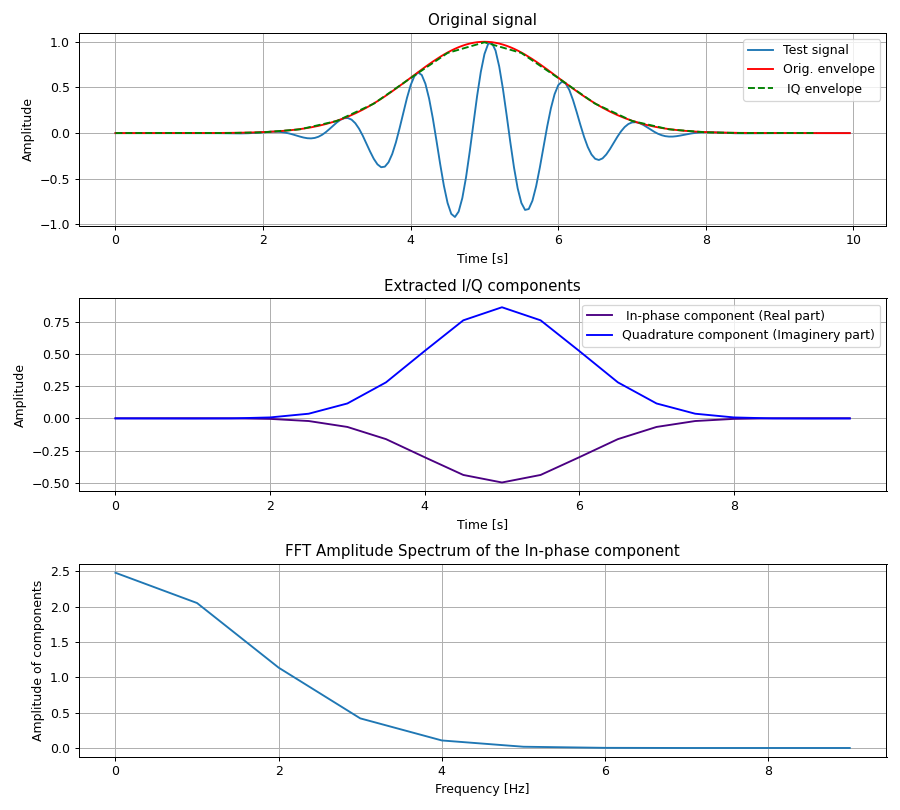

In [10]:
# Prepare the data and rund IQ demodulation and decimation
f_data_2D = f_data.reshape(1, -1)
dd_data = demodulate_decimate(f_data_2D, f_s, f_signal, decimation_factor)

# Extract I and Q components
Q_data = dd_data[0,:].real
I_data = dd_data[0,:].imag
dd_envelope = np.abs(dd_data[0,:])

# Make an array of time points to match decimated signal [s]
# The last argument is a step between the timepoints defined by the sampling period
t_decim = np.arange(0,10, 1/(f_s/decimation_factor))

# Plot the signal and its envelope
fig = plt.figure(figsize=(10, 9), dpi=90)
ax_1 = fig.add_subplot(311)
ax_2 = fig.add_subplot(312)
ax_3 = fig.add_subplot(313)

ax_1.grid()
ax_1.plot(t, f_data_2D[0, :], label='Test signal')
ax_1.plot(t, gauss_env, color='red', label='Orig. envelope')
ax_1.plot(t_decim, dd_envelope, color='green', linestyle='dashed', label=' IQ envelope')
ax_1.legend()
ax_1.set_xlabel('Time [s]')
ax_1.set_ylabel('Amplitude')
ax_1.set_title('Original signal')

# Plot I and Q components
ax_2.grid()
ax_2.plot(t_decim, I_data, color='indigo', label=' In-phase component (Real part)')
ax_2.plot(t_decim, Q_data, color='blue', label='Quadrature component (Imaginery part)')
ax_2.legend()
ax_2.set_xlabel('Time [s]')
ax_2.set_ylabel('Amplitude')
ax_2.set_title('Extracted I/Q components')

# Calculate FFT of I data
freqs, fft = calc_fft(I_data, f_s)

# Plot the FFT 
ax_3.grid()
ax_3.plot(freqs, np.abs(fft))
ax_3.set_xlabel('Frequency [Hz]')
ax_3.set_ylabel('Amplitude of components')
ax_3.set_title('FFT Amplitude Spectrum of the In-phase component')

plt.tight_layout()
plt.show()

### $\color{green}{\textbf{Task 1.3: Implement the envelope instruction using Hilbert transform}}$
**Hilbert transform** is another method to extract the envelope of the signal.
- The transform **does not change amplitude spectrum** of the signal. 
- However, **the positive frequency spectral components of a signal are shifted by (-90°)** and the phase angles of all the negative frequency spectral components are shifted by (+90°)
- That means if our signal is a sine wave

    $S_{RF}(t) = A(t)\cdot sin(2\pi f_{c}\cdot t + \phi)$
    
    Then its Hilbert transform is a negative cosine
    
    $H(S_{RF}(t)) = A(t)\cdot sin(2\pi f_{c}\cdot t - \pi/2 + \phi) = -A(t)\cdot cos(2\pi f_{c}\cdot t + \phi)$
    
    
- And we can calculate the envelope $A(t)$ as the follows:

    $A(t) = \sqrt{(S_{RF}(t))^2 + H(S_{RF}(t))^2}$ 

#### Tasks:
1. Implement the envelope extraction from the test signal with Hilbert transform using `scipy.signal.hilbert` function.
2. Visualize the results:
    - Plot the original signal next to Hilbert transformed signal
    - Plot the extracted envelope

In [11]:
from scipy import signal as ss
import numpy as np

# Extract the envelope with Hilbert transform

### Put your code here START

S_hilbert = ss.hilbert(f_data_2D)
amplitude_envelope = np.sqrt(np.abs(f_data_2D)**2 + np.abs(S_hilbert)**2)
instantaneous_phase = np.unwrap(np.angle(S_hilbert))
instantaneous_frequency = (np.diff(instantaneous_phase) / (2.0*np.pi) * f_s)

### Put your code here END

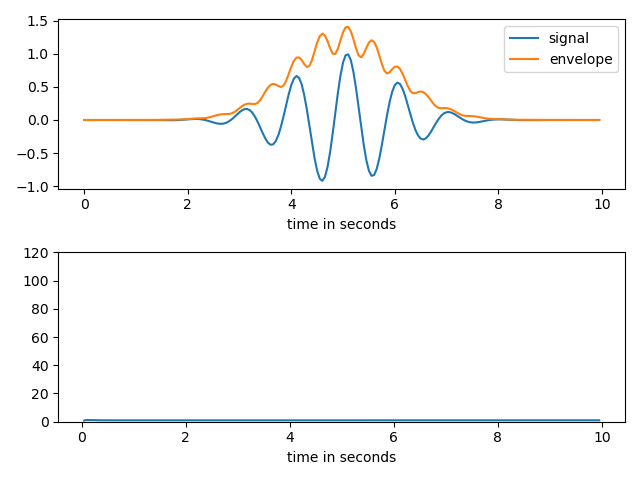

In [12]:
# Plot the signal and its envelope

### Put your code here START

fig, (ax0, ax1) = plt.subplots(nrows=2)
ax0.plot(t, f_data_2D.flatten(), label='signal')
ax0.plot(t, amplitude_envelope.flatten(), label='envelope')
ax0.set_xlabel("time in seconds")
ax0.legend()
ax1.plot(t[1:], instantaneous_frequency.flatten())
ax1.set_xlabel("time in seconds")
ax1.set_ylim(0.0, 120.0)
fig.tight_layout()


### Put your code here END

## $\color{green}{\textbf{Task 2: Analyse the real US raw data}}$
In this task, you will analyse **real US data** acquired from ultrasound phantom.

Before we start, we need to install a few extra packages.
   - First of all, open a separate terminal and activate the environent:
    
`conda activate wups_env`

   - Then, install a few packages (one by one) using the commands below, **make sure to follow this exact order**, otherwise you might get an error:
    
`conda install plotly`

`conda install -c plotly plotly-orca`

`conda install h5py`

`conda install numba`
   - You will use the [PyBF library](https://github.com/Sergio5714/pybf) which we kindly downloaded for you and placed in the subfolder called `pybf`.
   
**Note**: If you leave this script running when you install the packagese make sure to restart the kernel re-run the relevant cells above (e.g. the cells where packages are imported).

### $\color{green}{\textbf{Task 2.1: Visualize the test signal and calculate the FFT}}$
The `test_arr` below contains a time trace acquired from a single channel ultrasound system. Visualize the signal and calculate its FFT Amplitude spectrum.

The sampling frequency is $f_s = 20.832$ MHz

**Hint**: Use the helper function `calc_fft` defined above to calculate the FFT.

In [13]:
# Load the data from csv file
test_arr = np.genfromtxt('raw_us_data.csv', delimiter=',')

In [14]:
# Plot the signal

### Put your code here START



### Put your code here END

In [15]:
# Set sampling  frequency of the signal
f_s = 20.832 * (10 ** 6)

# Calculate and plot the FFT
### Put your code here START

# Calculate FFT


# Plot the FFT 


### Put your code here END

### $\color{green}{\textbf{Task 2.2: Find the central frequency}}$

Central frequency of the transducer is its carrier frequency. It is the frequency at which **the transducer is most excitable** - this is a physical property inherent to the transducer. Thus, it has the highest amplitude in the FFT Amplitude spectrum.

- Estimate the central frequency of the transducer from the data

**Hint**: Apply a low-pass filter prior to calculating any extrema. Use the functions `scipy.signal.butter` and `scipy.signal.filtfilt`. Consult Exercise 1 if you don’t remember how to implement a low pass filter.

In [16]:
from scipy.signal import butter, filtfilt

# Generate the coefficents for a low pass filter, and apply the filter

### Put your code here START

# Generate the filter coefficients for low pass filter


# Apply the filter


### Put your code here END

In [17]:
# Visualize the filtered signal

### Put your code here START



### Put your code here END

In [18]:
# Calculate the central frequency from the filtered waveform

### Put your code here START
f_cen_est = 

### Put your code here END

print('Frequency of max amplitude [Hz]:', f_cen_est)

SyntaxError: invalid syntax (3192781773.py, line 4)

### $\color{green}{\textbf{Task 2.3: Remove unwanted frequencies from the original raw data signal}}$
**Hint**: Design a bandpass digital filter and filter the signal. Choose the parameters of the filter (passband, etc) based on the FFT signal.

In [ ]:
### Put your code here START

# Generate the filter coefficients for band pass filter


# Apply the filter


# Calculate FFT


# Plot the FFT 


### Put your code here START

In [ ]:
# Plot the filtered ultrasound signal

### Put your code here START



### Put your code here END

### $\color{green}{\textbf{Task 2.4: Extract envelope using Demodulation Decimation}}$
**Hint**: Use the function `demodulate_decimate` defined above

In [ ]:
### Put your code here START

# Prepare the data and run IQ demodulation and decimation


# Extract envelope


# Plot the signal and its envelope


### Put your code here END

# B-mode imaging and beamforming

- B-mode imaging is a modality invloving multiple US transducer channels
- **B-mode** stands for **brightness mode**. 
- Ultrasound **B-mode images are reflectivity maps** where bright pixels correspond to the highly reflective areas.
  Similarly, the pixels with low intensity correpond to the areas with low-reflectivity.

An example ultrasound image of the Common Carotid Artery is shown below:

<img src='images/ex6_carotid_us_imag_0.drawio.png'>

- The top part of the image corresponds to the superficial tissues (close to the skin surface) while the bottom part of the image shows deep tissue.
- Z axis is prependicular to the skin surface and x axis is parallel  to the skin surface.

#### How to reconstruct an image from raw US data?

- **To reconstruct the ultrasound image** from raw data, we employ an algorithm called **beamformer**.
- The process of image reconstruction is, respectively, called **beamforming**.
- The most common beamforming algorithm is **Delay-and-Sum (DAS)** algorithm. The block diagram of the algorithm is shown below:

<img src='images/ex6_beamforming.drawio.png'>

- Most of the building blocks we already know (marked with green).
- The orange blocks are new for us. The most important of them is **Delay and Sum (DAS) block**.
- Before the DAS block, the data from multiple channels are processed separately.
- DAS is a key step, when the data from transducer channels are combined together to build an Ultrasound image.

The diagram below conceptually visualizes the calculations of DAS block for each pixel of the output image.
- Each pixel (Source) has fixed coordinates $(x_0, z_0)$. Its position with respect to the transducer channels is known.
- **The distances** from the source to each channel **are different**.Therefore, a reflected pressure wave takes different amount of time to travel back to the transducer channels. 
- That means, **the same backscattered signal** captured by **different transducer channels** appears **delayed in time**.
- **DAS** algorithm **applies compensating delays** (based on relative positions of the source and channels) and **aligns the received signals in time**.

- Then, **DAS sums up the aligned signals** from different channels. Constructive interference increases the amplitude of the reflected signal. Instead, if we would not have a scatterer at the position of the source, we would sum up some noise with undefined phase (destructive interference).

- The normalization step is optional

- **The process** described above **repeats for every pixel** of the image. That is how we reconstruct an image with DAS block

<img src='images/ex6_beamforming_das.drawio.png'>

- In the next part of the exercise, you will explore the unknown (orange) blocks by experimenting with the Python implemetation of DAS algorithm provided by [PyBF library](https://github.com/Sergio5714/pybf).

### Beamforming example

#### Import the library and the data

In [ ]:
# Import PyBF library
import sys

path_to_lib = '.'
sys.path.insert(0, path_to_lib)

from pybf.scripts.beamformer_cartesian_realtime import BFCartesianRealTime
from pybf.pybf.transducer import Transducer
from pybf.pybf.image_settings import ImageSettings
from pybf.pybf.visualization import plot_image

# Load raw RF data
rf_data = np.genfromtxt('raw_data_beamforming.csv', delimiter=',')

#### Create a Transducer object

In [ ]:
### Specify Trancducer settings and create transducer object ###

# Transducer sttings
F_CENTRAL = 5.13 * 10 ** 6
X_ELEM = 128
X_PITCH = 0.0003
X_WIDTH = 0
Y_ELEM = 1
Y_PITCH = 0
Y_WIDTH = 0

# Set all transducer elements (channels) to be active by default
active_elements = np.arange(X_ELEM)

# Select every 2nd channels to be active
# active_elements = active_elements[::2]

# Select 64 central channels to be active
# active_elements = active_elements[32:96]

# Select 32 central channels to be active
# active_elements = active_elements[48:80]

trans = Transducer(num_of_x_elements=X_ELEM,
                   num_of_y_elements=Y_ELEM,
                   x_pitch=X_PITCH,
                   y_pitch=Y_PITCH,
                   x_width=X_WIDTH,
                   y_width=Y_WIDTH,
                   f_central_hz=F_CENTRAL,
                   bandwidth_hz=F_CENTRAL,
                   active_elements=active_elements)


#### Create and ImageSettings object

In [ ]:
### Specify Image settings and create corresponding object ###
img_res = [400, 600]
image_x_range = [-0.018, 0.018]
image_z_range = [0.000, 0.045]

LATERAL_PIXEL_DENSITY_DEFAULT = 5

img_config = ImageSettings(image_x_range[0],
                           image_x_range[1],
                           image_z_range[0],
                           image_z_range[1],
                           LATERAL_PIXEL_DENSITY_DEFAULT,
                           trans)

#### Specify preprocessing parameters and beamformer settings

In [ ]:
### Specify preprocessing parameters for RF data ###

decimation_factor = 1
interpolation_factor = 10

### Specify TX strategy and Apodization parameters ###

start_time = 0
correction_time_shift = 0

alpha_fov_apod = 40

# 1 Plane waves with inclination angle 0
tx_strategy = ['PW_1_0', [0]]

### Specify Sampling Frequency ###

SAMPLING_FREQ = 20.832 * (10 ** 6)

bp_filters_params = [1 * 10 **6, 8 * 10 **6, 0.5 * 10 **6]

In [ ]:
# Create an instance of beamformer
bf = BFCartesianRealTime(SAMPLING_FREQ,
                         tx_strategy,
                         trans,
                         decimation_factor,
                         interpolation_factor,
                         img_res,
                         img_config,
                         start_time=start_time,
                         correction_time_shift=correction_time_shift,
                         alpha_fov_apod=alpha_fov_apod,
                         bp_filter_params=bp_filters_params)

# Run beamformer
img_data = bf.beamform(rf_data[active_elements])

In [ ]:
# Plot image and save it.
plot_image(np.abs(img_data), 
           scatters_coords_xz=None,
           elements_coords_xz=trans.elements_coords,
           framework='matplotlib',
           title='Sample Image',
           image_x_range=image_x_range,
           image_z_range=image_z_range,
           db_range=50,
           colorscale='Greys',
           save_fig=False, 
           show=True,
           path_to_save='.')

## $\color{green}{\textbf{Task 3: Explore the PyBF example code}}$

### $\color{green}{\textbf{Task 3.1: Explore the image settings object}}$
Play with the input parameters of the `ImageSettings` constructor to adapt the resolution and position of the image.

**Hint**: Change the lists `image_x_range` and `image_z_range` to change the location, width and hight of the reconstructed image.

Answer the following question:
- Given the speed of sound $c = 1540\;m/s$ and the data we have, calculate the maximum imaging depth. Do not forget to account for the decimation factor, which reduced the amount of samples we have. A decimation factor of 1 means we discard every second sample.

- Change the list `image_z_range` to match the maximum imaging depth

- Then, reconstruct the image and calculate the number of scatters you can spot in the image.
  
- Answer the quiz

**Note**: There is a white spot in the image that is not a scatter but an inclusion. Please, do not count it.

In [ ]:
from jupyterquiz import display_quiz
load_quiz(2)

### $\color{green}{\textbf{Task 3.2: Play with the number of input channels}}$
You can reconstruct the image from a data with different number of channels.
This parameter is controlled by the parameter `active_elements` of the `Transducer` object. This array contains indices of the transducer channels (ranging from 0 to 127) which we would like to activate. It means the information only from these channels will be used during the beamforming.  

- Modify this parameter to imitate the transducer with different number of channels. We have prepared a few `active_elements` configurations for you. Just uncomment them one by one and run again the beamforming.
- Compare the quality of the images reconstructed with different number of channels. Discuss your observations with the TAs.

### $\color{green}{\textbf{Task 3.3: Visualize DAS output}}$
Visualize the output of DAS beamformer after computing the absolute value of the complex signal.

- What can you say about the image? Can we see fine structures in the US image?
- Discuss your observations with the TAs.

**Note**: Use the function `plt.imshow` with the parameter `cmap="gray"` to visualize the data.

In [ ]:
from matplotlib import pyplot as plt

### Put your answer here START

# Plot the signal and its envelope
plt.figure()

plt.imshow(np.abs(img_data), cmap="gray")
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.title('Original signal')

### Put your answer here END

### $\color{green}{\textbf{Task 3.4: Logarithmic compression}}$
The output of DAS tupically undergo logarithmic compression to visualize both structures with low and high reflectivity.

- Play with the parameter `db_range` of the `plot_image` function. This parameter preserves only those signals that are no more than X decibels (dBs) lower in intensity compared to the maximum value of the image.
Higher the decibel range, more fine (low-intensity) structures are visible in the image.